In [1]:
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np

Loaded 15 images for calibration.


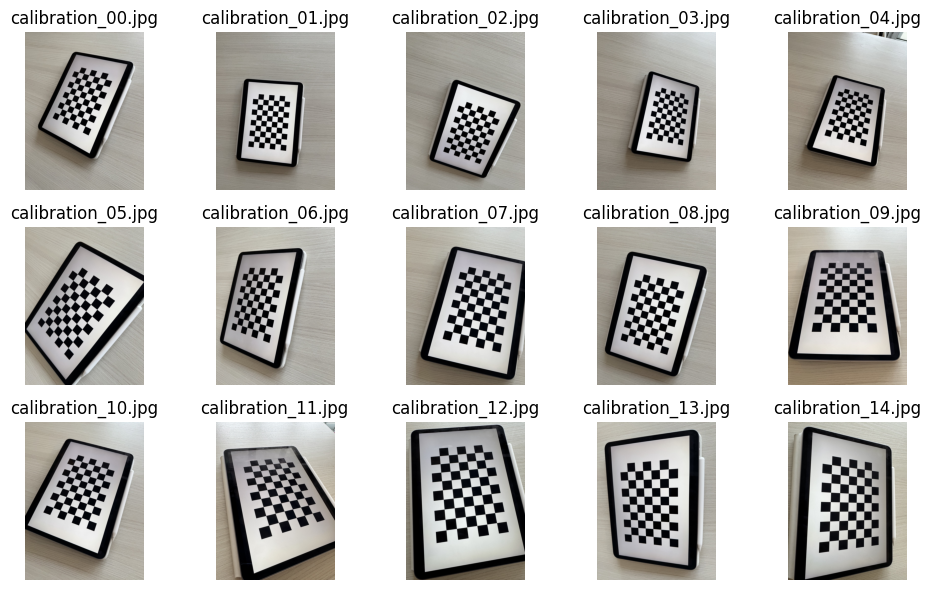

In [2]:
# Load the images for calibration
path = '../assets/calibration'
images = {}
for filename in sorted(os.listdir(path)):
    if filename.endswith('.jpg'):
        img = cv2.imread(os.path.join(path, filename), cv2.IMREAD_COLOR_RGB)
        images[filename] = img

print(f'Loaded {len(images)} images for calibration.')

# Display the images (there should be 15, so 3 rows, 5 columns)
fig, axs = plt.subplots(3, 5, figsize=(10, 6))
for i, (filename, img) in enumerate(images.items()):
    ax = axs[i // 5, i % 5]
    ax.imshow(img, cmap='gray')
    ax.set_title(filename)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [3]:
# Termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images
objpoints = [] # 3D point in real world space
imgpoints = [] # 2D points in image plane

for name, image in images.items():
    print(f'Processing {name}...', end='')

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(image, (9,6), None)

    # If found, add object points, image points (after refining them)
    if ret:
        print(' -> Found corners.')

        objpoints.append(objp)

        # Refine the corners
        corners2 = cv2.cornerSubPix(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY), corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
        cv2.drawChessboardCorners(image, (9,6), corners2, ret)
        cv2.imshow('img', image)
        cv2.waitKey()
    else:
        print(' -> No corners found.')

cv2.destroyAllWindows()

Processing calibration_00.jpg... -> Found corners.
Processing calibration_01.jpg... -> Found corners.
Processing calibration_02.jpg... -> Found corners.
Processing calibration_03.jpg... -> Found corners.
Processing calibration_04.jpg... -> Found corners.
Processing calibration_05.jpg... -> Found corners.
Processing calibration_06.jpg... -> Found corners.
Processing calibration_07.jpg... -> Found corners.
Processing calibration_08.jpg... -> Found corners.
Processing calibration_09.jpg... -> Found corners.
Processing calibration_10.jpg... -> Found corners.
Processing calibration_11.jpg... -> Found corners.
Processing calibration_12.jpg... -> Found corners.
Processing calibration_13.jpg... -> Found corners.
Processing calibration_14.jpg... -> Found corners.


In [5]:
# Load the first image
sample_img = images[list(images.keys())[0]]

# Get the image size (width, height)
image_size = sample_img.shape[1], sample_img.shape[0]

# 1. Calibrate camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
    objpoints, imgpoints, image_size, None, None
)
print("RMS reprojection error:", ret)

# 2. Refine camera matrix
new_mtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, image_size, 1, image_size)

# 3. Build undistort maps (if streaming)
mapx, mapy = cv2.initUndistortRectifyMap(
    mtx, dist, None, new_mtx, image_size, cv2.CV_32FC1
)

# 4. Undistort a sample
undist = cv2.remap(sample_img, mapx, mapy, cv2.INTER_LINEAR)
x,y,w,h = roi
undist = undist[y:y+h, x:x+w]

cv2.imshow('undistorted', undist)
cv2.waitKey(0)
cv2.destroyAllWindows()

RMS reprojection error: 0.7138006061725426


In [6]:
import json

def save_calibration_json(filename, camera_matrix, dist_coeff, image_size):
    data = {
        'camera_matrix': camera_matrix.tolist(),
        'dist_coeff': dist_coeff.tolist(),
        'image_size': list(image_size)
    }

    with open(filename, 'w') as f:
        json.dump(data, f, indent=2)


def load_calibration_json(filename):
    with open(filename) as f:
        data = json.load(f)

    camera_matrix = np.array(data['camera_matrix'])
    dist_coeff = np.array(data['dist_coeff'])
    image_size = tuple(data['image_size'])

    return camera_matrix, dist_coeff, image_size


In [7]:
# Save to JSON
save_calibration_json('../assets/camera_calibration.json', mtx, dist, image_size)

In [9]:
# Load later
mtx, dist, image_size = load_calibration_json('../assets/camera_calibration.json')

print("Camera matrix:\n", mtx)
print("Distortion coefficients:\n", dist)
print("Image size:\n", image_size)

Camera matrix:
 [[894.67311331   0.         485.2289589 ]
 [  0.         896.1589482  633.03618469]
 [  0.           0.           1.        ]]
Distortion coefficients:
 [[ 0.0959633   0.12784815  0.00436388  0.00226419 -2.07290104]]
Image size:
 (960, 1280)
